#### Importing necessary modules:

In [1]:
# These Python modules are necessary for processing the data and also for visualisations.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Study of Wake effect as described by the N. O. Jensen model:

##### Defining a Wind Turbine:

In [2]:
class WindTurbine(object):
    def __init__(self, rotor_D, hub_h, Ct, alpha, x, y, V) -> None:
        self.rotor_D = rotor_D # Rotor diameter (m)
        self.hub_h = hub_h # Hub-height (m)
        
        # Position of Turbine in plane: (x +ve downstream)
        self.x = x
        self.y = y

        # Initial undisturbed upstream wind experienced by Turbine blades
        self.V = V
        
        self.Ct = Ct # Coefficient of thrust
        self.alpha = alpha # Linear wake expansion factor

##### The N. O. Jensen Wake Deficit Model:

In [3]:
def jensen_model_deficit(WT: WindTurbine, x_down, ):
    """
    N. O. Jensen model for wake velocity deficit

    Parameters: (vectorized)
    V0 : float
        Free stream wind speed (m/s)
    rotor_D : float
        Rotor diameter of the turbine (m)
    alpha: float
        Wake expansion factor
    x_down : float
        Distance downstream from the turbine (m)
    Ct : float
        Rotor thrust coefficient (m)

    Returns: (vectorized)
    float
        Wake velocity deficit at different distances behind the turbine (m/s)
    """
    V0, Ct, rotor_D, alpha, = WT.V, WT.Ct, WT.rotor_D, WT.alpha,

    rotor_r = rotor_D/2
    wake_r = rotor_r + alpha*x_down

    wake_deficit = np.where(wake_r>=rotor_r,V0*(1-np.sqrt(1-Ct))*np.power(rotor_r/wake_r,2),0) # If 'x_down' is negative 'Wake deficit' is not defined (0)
    return wake_deficit

##### Testing the Single Wake model:

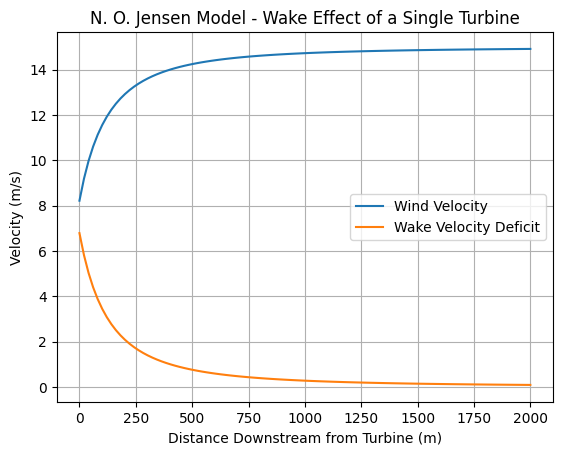

In [4]:
# Parameters:

V = float(input("Free stream wind speed (m/s):")) # Free stream wind speed (m/s)
rotor_D = float(input("Enter rotor diameter(m):"))   # Rotor diameter of the turbine (m)

hub_h = int(input("Hub-height:")) # Hub height of the turbine
z0 = float(input("Surface roughness factor:"))   # Surface roughness coefficient
alpha = 1/(2*np.log(hub_h/z0))
alpha = 0.04 # Common value

Ct = float(input("Enter the thrust coefficient:")) # Thrust coefficient of turbine

# Defining the Wind Turbine
WT = WindTurbine(rotor_D, hub_h, Ct, alpha, 0, 0, V)

# Distance range
x_range = np.linspace(0, 100 * WT.rotor_D, 100)

# Calculate the wake velocity deficit
vel_deficit = jensen_model_deficit(WT, x_range,)
wake_velocity = WT.V - vel_deficit

# Plot the wake velocity and deficit
plt.plot(x_range, wake_velocity, label='Wind Velocity')
plt.plot(x_range, vel_deficit, label='Wake Velocity Deficit')
plt.xlabel('Distance Downstream from Turbine (m)')
plt.ylabel('Velocity (m/s)')
plt.title('N. O. Jensen Model - Wake Effect of a Single Turbine')
plt.legend()
plt.grid()
plt.show()


##### Implementing Multiple Wake Superposition and Area Overlap modelling methods:

In [5]:
def calc_shadow_coeff(WT1:WindTurbine,WT2:WindTurbine):
    """
    Calculate the area of shadow cast on the area swept by turbine WT2, 
    by the Wake circle of the turbine WT1.

    Returns the fractional portion of WT2 area covered.
    """
    
    # As shadow is only cast by upstream turbine on downstream turbine
    if(WT1.x >= WT2.x):
        return 0
    
    dx_12 = WT2.x - WT1.x

    R = WT1.rotor_D/2 + WT1.alpha * dx_12
    r = WT2.rotor_D/2

    dy_12 = np.abs(WT2.y - WT1.y)
    if(dy_12==0): # Full overlap
        # return np.pi*(r**2) 
        return 1

    z_12 = (r**2 - (R-dy_12)**2) * ((R+dy_12)**2 - r**2) / (2*(dy_12**2))
    if(z_12<=0): # No overlap
        return 0
    
    l_12 = (dy_12**2 + R**2 - r**2) / (2*dy_12)

    # A_shadow = Sector + Sector - Kite ; (Partial overlap)
    return ((R**2)*np.arccos(l_12/R) + (r**2)*np.arccos((dy_12-l_12)/r) - dy_12*z_12/2) / np.pi*(r**2)

def calc_WT_vel_superposition(WT:WindTurbine,turbines):
    """
    Calculates and updates the net velocity experienced by turbine WT, 
    from upstream, owing to the cumulative Wake effect of all 
    upstream Wind Turbines, calculated using momentum-conserved superposition.
    """
    vel_deficit = 0
    for wt in turbines:
        if(wt.x>=WT.x):
            break
        vel_deficit += calc_shadow_coeff(wt,WT)*(jensen_model_deficit(wt, WT.x-wt.x)**2)
    
    vel_deficit = np.sqrt(vel_deficit)

    # Updating the effective velocity of oncoming upstream wind, after superposition of Wake effects.
    WT.V = WT.V - vel_deficit

def calc_point_vel_superposition(V,x,y,turbines):
    """
    Calculate the net wind speed at a point in the plane, 
    due to the cumulative effects of all upstream Wakes.

    Parameters:

    x : float
        The x co-ordinate of the point in plane
    y : float
        The y co-ordinate of the point in plane
    V : float
        The undisturbed wind speed at point.
    turbines : array of WindTurbine elements
        The description of all WT's in the farm
    """
    vel_deficit = 0
    # count = 0
    for wt in turbines:
        if(wt.x>x):
            break
        if(np.abs(wt.y - y) <= (wt.rotor_D/2 + wt.alpha*(x - wt.x))):
            vel_deficit += jensen_model_deficit(wt, x - wt.x)**2
            # count += 1
     
    # vel_deficit = np.sqrt(vel_deficit/(count if (count!=0) else 1))
    vel_deficit = np.sqrt(vel_deficit)


    return V - vel_deficit


##### Testing Multiple Wake effects on a Wind Farm:

In [6]:
# Description of the Wind Farm layout and Turbine specification:

# WT specifications
rotor_D, hub_h, Ct, alpha = 20, 100, 0.7, 0.04

# Wind Farm layout:
V = 15 
seperation  = 7 * rotor_D
rows = 5
columns = 4

In [7]:
# Initializing WT's according to layout and specifications.
turbines = np.empty(shape=(rows,columns),dtype=np.dtype("object"))
for i in range(rows):
    for j in range(columns):

        # Assigning the position of WT on plane (Grid configuration)
        x_co = seperation*j
        y_co = seperation*i
        
        # # Another configuration (Alternate Shifted Grid)
        # x_co = seperation*j 
        # y_co = seperation*i + seperation*(j%2)/2
        
        turbines[i,j] = WindTurbine(rotor_D,hub_h,Ct,alpha,x_co,y_co,V)

turbines = turbines.T.flatten() # Change the layout of the array from 2D to 1D.

# Defining the plane on which wind velocity field will be calculated.
x_range = np.linspace(-10,turbines[rows*columns - 1].x + seperation,500)
y_range = np.linspace(-3*rotor_D,turbines[rows*columns - 1].y+3*rotor_D,500)

# Calculating Wake effect over the entire Wind Farm:
for epoch in range(1): # Does not converge?
    for wt in turbines:
        calc_WT_vel_superposition(wt,turbines)

# Populating the planar space with wind calculated velocities
planar_wv_dist = np.empty(shape=(x_range.size,y_range.size),dtype=np.dtype("float64"))
for x_i in range(x_range.size):
    for y_i in range(y_range.size):
        planar_wv_dist[x_i,y_i] = calc_point_vel_superposition(V,x_range[x_i],y_range[y_i],turbines)

planar_wv_dist = planar_wv_dist.T

##### The Wind speeds faced by Different Turbines: (x-cordinate, y-cordinate, Velocity) 

In [8]:
for wt in turbines:
    print(f"Position:({wt.x},{wt.y}) Velocity: {wt.V} m/s")

Position:(0,0) Velocity: 15.0 m/s
Position:(0,140) Velocity: 15.0 m/s
Position:(0,280) Velocity: 15.0 m/s
Position:(0,420) Velocity: 15.0 m/s
Position:(0,560) Velocity: 15.0 m/s
Position:(140,0) Velocity: 12.212293870224151 m/s
Position:(140,140) Velocity: 12.212293870224151 m/s
Position:(140,280) Velocity: 12.212293870224151 m/s
Position:(140,420) Velocity: 12.212293870224151 m/s
Position:(140,560) Velocity: 12.212293870224151 m/s
Position:(280,0) Velocity: 12.274257841967463 m/s
Position:(280,140) Velocity: 12.274257841967463 m/s
Position:(280,280) Velocity: 12.274257841967463 m/s
Position:(280,420) Velocity: 12.274257841967463 m/s
Position:(280,560) Velocity: 12.274257841967463 m/s
Position:(420,0) Velocity: 12.242093196562923 m/s
Position:(420,140) Velocity: 12.242093196562923 m/s
Position:(420,280) Velocity: 12.242093196562923 m/s
Position:(420,420) Velocity: 12.242093196562923 m/s
Position:(420,560) Velocity: 12.242093196562923 m/s


##### The resultant velocity field in the Wind Farm:

In [9]:
def plot_wind_speed_contour(wind_speeds):
    """
    Plot a contour plot of wind speeds on a 2D plane.

    Parameters:
        wind_speeds (np.ndarray): 2D array of wind speeds.

    Returns:
        None (displays the plot)
    """
    # Create a meshgrid for the x and y coordinates
    x = np.arange(0, wind_speeds.shape[1])
    y = np.arange(0, wind_speeds.shape[0])
    X, Y = np.meshgrid(x, y)

    # Create the contour plot
    plt.figure(figsize=(10, 6))
    plt.contourf(X, Y, wind_speeds, levels=150, cmap='viridis')
    plt.colorbar(label='Wind Speed (m/s)')

    # Add labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Wind Speed Contour Plot')

    # Remove ticks on axes
    plt.xticks([])
    plt.yticks([])

    # Show the plot
    plt.show()


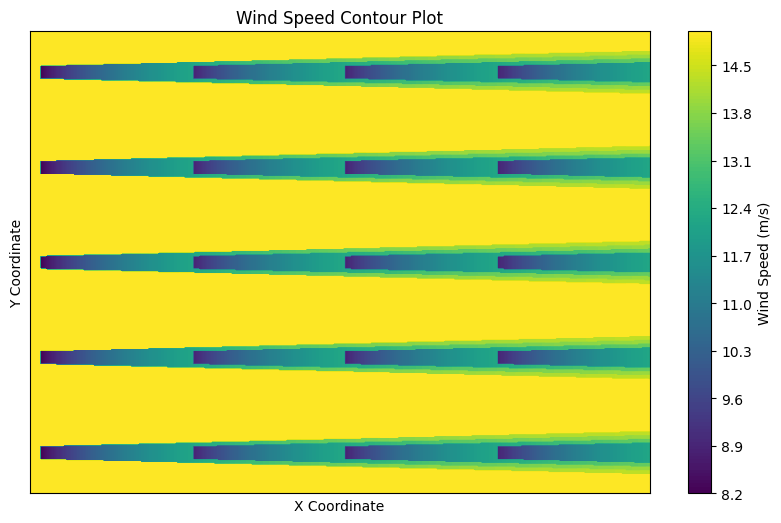

In [10]:
plot_wind_speed_contour(planar_wv_dist)

#### Power output calculations and characteristic curves:

##### Importing and organising the Wind and Power Output data:

In [11]:
path = ".\wind_data.txt"

windpower_data = pd.read_csv(path,sep='\t')
windpower_data.head()

,Date(YYYY-MM-DD hh:mm:ss),W,P
0,01-01-2006 00:00,5.12,1.788
1,01-01-2006 00:10,5.12,1.788
2,01-01-2006 00:20,5.14,1.812
3,01-01-2006 00:30,5.17,1.848
4,01-01-2006 00:40,5.24,1.929


In [12]:
windpower_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date(YYYY-MM-DD hh:mm:ss)  52560 non-null  object 
 1   W                          52560 non-null  float64
 2   P                          52560 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.2+ MB


In [13]:
date_format = "%d-%m-%Y %H:%M"
windpower_data["Date(YYYY-MM-DD hh:mm:ss)"] = pd.to_datetime(windpower_data["Date(YYYY-MM-DD hh:mm:ss)"],format=date_format)
# windpower_data["P"] = windpower_data["P"] / 100 # Converting to MW

In [14]:
windpower_data.set_index("Date(YYYY-MM-DD hh:mm:ss)",inplace=True)
windpower_data.rename_axis(index=[None, ],inplace=True)
windpower_data.rename(columns={"W":"Wind Speed (m/s)", "P":"Actual Power Output (MW)", },inplace=True)

In [15]:
windpower_data.head()

,Wind Speed (m/s),Actual Power Output (MW)
2006-01-01 00:00:00,5.12,1.788
2006-01-01 00:10:00,5.12,1.788
2006-01-01 00:20:00,5.14,1.812
2006-01-01 00:30:00,5.17,1.848
2006-01-01 00:40:00,5.24,1.929


##### Defining the Power Curve of the Vestas V90 1.8MW Wind Turbine:

In [16]:
def power_out(vel, rated_p=1.8, cut_in_v = 4, cut_out_v = 25, rated_v = 15):
    """
    Returns the power output of a WT (mega watts) given upstream wind speed 'vel' (m/s)
    Default values are chosen of the Vestas V90 1.8 MW Wind Turbine
    """
    return np.where(vel>=cut_in_v ,np.where(vel<rated_v ,rated_p*(vel**3-cut_in_v**3)/(rated_v**3-cut_in_v**3),np.where(vel<=cut_out_v,rated_p,0)),0)

In [17]:
# Calculating the theoretical power output at different wind speeds:
windpower_data["Theoretical Power Output (MW)"] = power_out(windpower_data["Wind Speed (m/s)"])
windpower_data.head()

,Wind Speed (m/s),Actual Power Output (MW),Theoretical Power Output (MW)
2006-01-01 00:00:00,5.12,1.788,0.038173
2006-01-01 00:10:00,5.12,1.788,0.038173
2006-01-01 00:20:00,5.14,1.812,0.039032
2006-01-01 00:30:00,5.17,1.848,0.040332
2006-01-01 00:40:00,5.24,1.929,0.043425


##### Visualising the Offshore Wind Speed data:

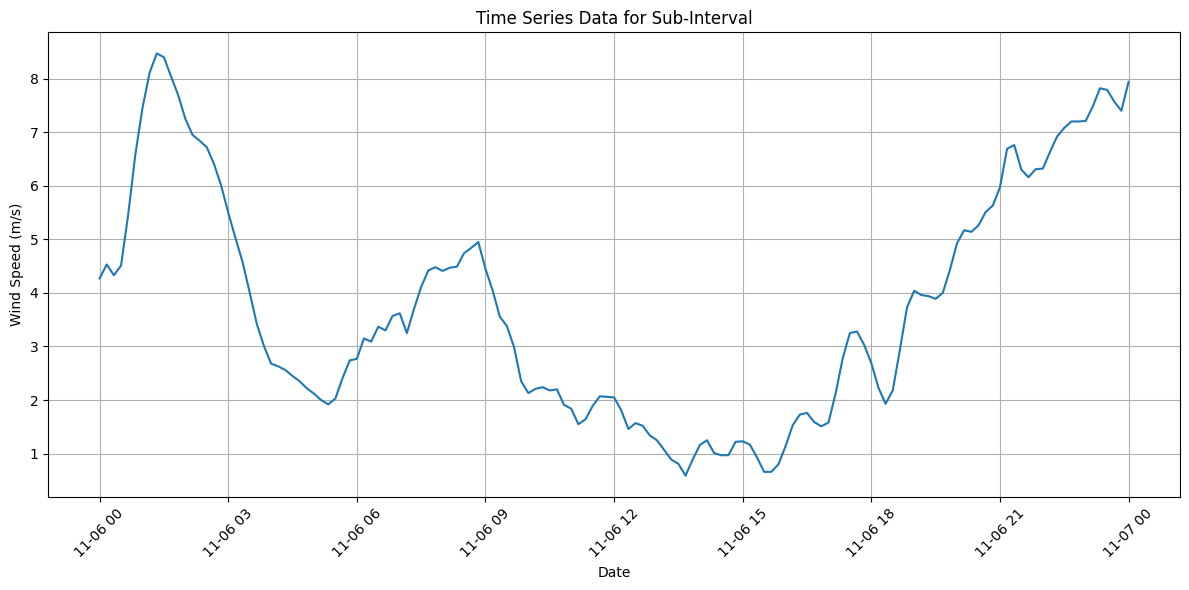

In [18]:
# The wind speed data over a period of time visualised:
plt.figure(figsize=(12, 6))

start_date = '2006-11-06 00:00'
end_date = '2006-11-07 00:00'
data_subinterval = windpower_data.loc[start_date:end_date]

# plt.plot(data_subinterval.index, data_subinterval['P'], marker='.', linestyle='-')
plt.plot(data_subinterval.index, data_subinterval['Wind Speed (m/s)'])

plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Time Series Data for Sub-Interval')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Visualising the Power Curves from given Wind Speed data:

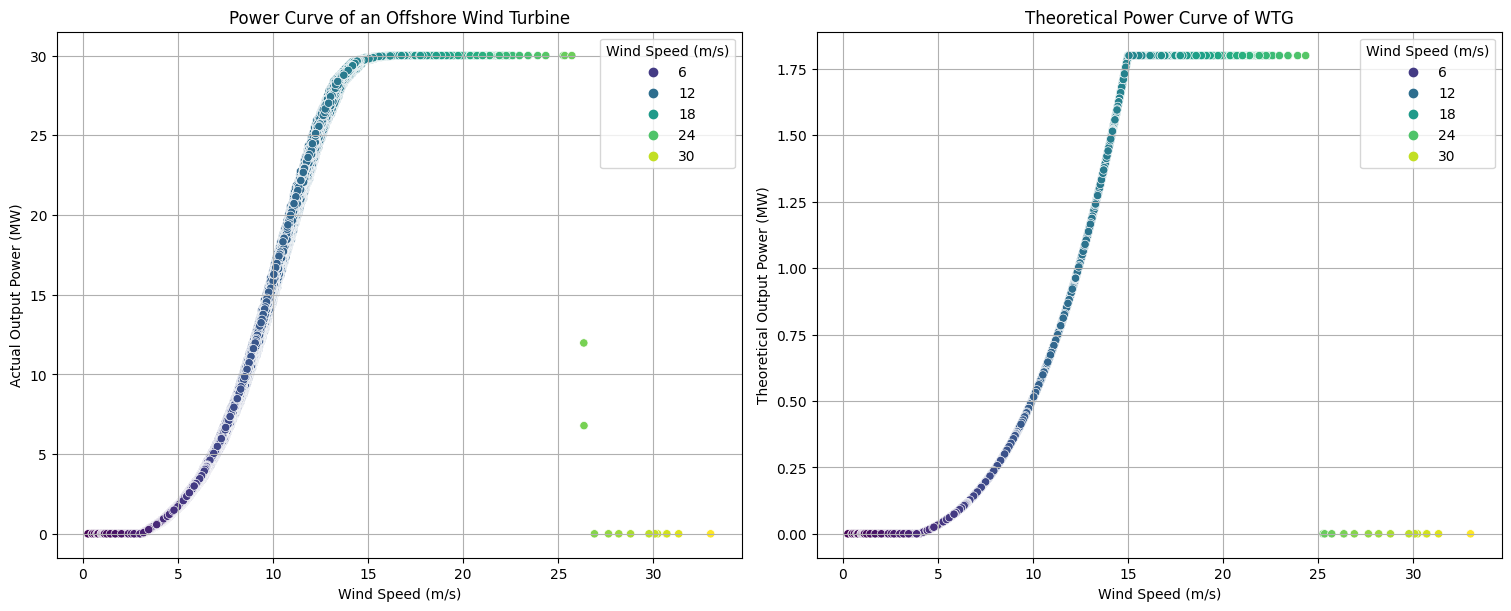

In [19]:
# The Power Curve (Output Power v.s. Wind Speed characteristics)

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,6),layout="constrained")

sns.scatterplot(windpower_data,x="Wind Speed (m/s)",y="Actual Power Output (MW)",hue="Wind Speed (m/s)",palette=sns.color_palette("viridis",as_cmap=True),ax=axs[0])

axs[0].grid()
axs[0].set_ylabel('Actual Output Power (MW)')
axs[0].set_xlabel('Wind Speed (m/s)')
# axs[0].set_facecolor("grey")
axs[0].set_title('Power Curve of an Offshore Wind Turbine')

sns.scatterplot(windpower_data,x="Wind Speed (m/s)",y="Theoretical Power Output (MW)",hue="Wind Speed (m/s)",palette=sns.color_palette("viridis",as_cmap=True),ax=axs[1])

axs[1].grid()
axs[1].set_ylabel('Theoretical Output Power (MW)')
axs[1].set_xlabel('Wind Speed (m/s)')
# axs[1].set_facecolor("grey")
axs[1].set_title('Theoretical Power Curve of WTG')


plt.show()